# Supervised Learning Model Evaluation - In-Class Exercises

In this notebook, you will practice evaluating supervised learning models using proper train-test splitting strategies, computing various evaluation metrics, and performing cross-validation with confidence intervals.

**Datasets:**
- **Titanic**: Binary classification (Survived: 0 or 1) - imbalanced dataset
- **Iris**: Multiclass classification (3 species) - balanced dataset

**Learning Objectives:**
- Implement proper train-test splitting strategies
- Compute and interpret evaluation metrics for binary and multiclass problems
- Calculate ROC curves
- Perform cross-validation with confidence intervals

## Setup: Import Libraries

All necessary imports are provided below.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# Set random seed for reproducibility
np.random.seed(42)

---
## Part 1: Binary Classification - Titanic Dataset

### Dataset Loading and Preprocessing

The code below loads and preprocesses the Titanic dataset. This is provided for you.

In [4]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Display first few rows and info
print("Dataset shape:", titanic.shape)
print("\nFirst few rows:")
display(titanic.head())
print("\nMissing values:")
print(titanic.isnull().sum())
print("\nClass distribution:")
print(titanic['survived'].value_counts())

Dataset shape: (891, 15)

First few rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Missing values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Class distribution:
survived
0    549
1    342
Name: count, dtype: int64


In [5]:
# Preprocessing: Select features and handle missing values
# Select relevant features
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Create a copy with selected features
df_titanic = titanic[features + [target]].copy()

# Handle missing values
# Fill missing age with median
df_titanic['age'] = df_titanic['age'].fillna(df_titanic['age'].median())

# Fill missing embarked with mode
df_titanic['embarked'] = df_titanic['embarked'].fillna(df_titanic['embarked'].mode()[0])

# Fill missing fare with median
df_titanic['fare'] = df_titanic['fare'].fillna(df_titanic['fare'].median())

# Encode categorical variables
df_titanic['sex'] = df_titanic['sex'].map({'male': 0, 'female': 1})
df_titanic = pd.get_dummies(df_titanic, columns=['embarked'], prefix='embarked', drop_first=True)

# Separate features and target
X_titanic = df_titanic.drop(target, axis=1)
y_titanic = df_titanic[target]

print("Preprocessed dataset shape:", X_titanic.shape)
print("Features:", list(X_titanic.columns))
print("\nNo missing values remaining:", X_titanic.isnull().sum().sum())

Preprocessed dataset shape: (891, 8)
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked_Q', 'embarked_S']

No missing values remaining: 0


---
## ✏️ Exercise 1: Train-Test Split with Stratification

**Task:** Create a train-test split for the Titanic dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_titanic`, `X_test_titanic`, `y_train_titanic`, `y_test_titanic`

*Tip: For imbalanced datasets like Titanic, consider whether you want the same class distribution in both train and test sets. Check the `stratify` parameter in the documentation.*

In [8]:
# ===== STUDENT CODE START =====

# Exercise 1: Train-test split (70/30) with stratification
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(
    X_titanic,
    y_titanic,
    test_size=0.30,
    random_state=42,
    stratify=y_titanic
)

# ===== STUDENT CODE END =====

In [9]:
# Verify the split by checking shapes and class distributions
print("Train set shape:", X_train_titanic.shape)
print("Test set shape:", X_test_titanic.shape)
print("\nTrain set class distribution:")
print(y_train_titanic.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test_titanic.value_counts(normalize=True))

Train set shape: (623, 8)
Test set shape: (268, 8)

Train set class distribution:
survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Test set class distribution:
survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64


### Model Training Code 

Below is the model training code. **Warning** - you will need to create the train-test split first in Exercise 1.

In [10]:
# Train a Logistic Regression model
# This cell should be run AFTER you complete Exercise 1

model_titanic = LogisticRegression(max_iter=1000, random_state=42)
model_titanic.fit(X_train_titanic, y_train_titanic)

# Make predictions
y_pred_titanic = model_titanic.predict(X_test_titanic)
y_pred_proba_titanic = model_titanic.predict_proba(X_test_titanic)[:, 1]

print("Model trained successfully!")

Model trained successfully!


---
## ✏️ Exercise 2: Binary Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Titanic model:
1. Confusion Matrix
2. Accuracy
3. Precision
4. Recall
5. F1-Score
6. ROC-AUC Score

**Visualization Requirements:**
- Create a heatmap visualization of the confusion matrix using seaborn
- Plot the ROC curve with AUC score using matplotlib

*Tip: All these functions are available in `sklearn.metrics`. For ROC-AUC, you'll need predicted probabilities, not just class predictions.*

TITANIC DATASET - Binary Classification Metrics

Confusion Matrix:
[[139  26]
 [ 28  75]]

Accuracy: 0.7985
Precision: 0.7426
Recall: 0.7282
F1-Score: 0.7353
ROC-AUC Score: 0.8494


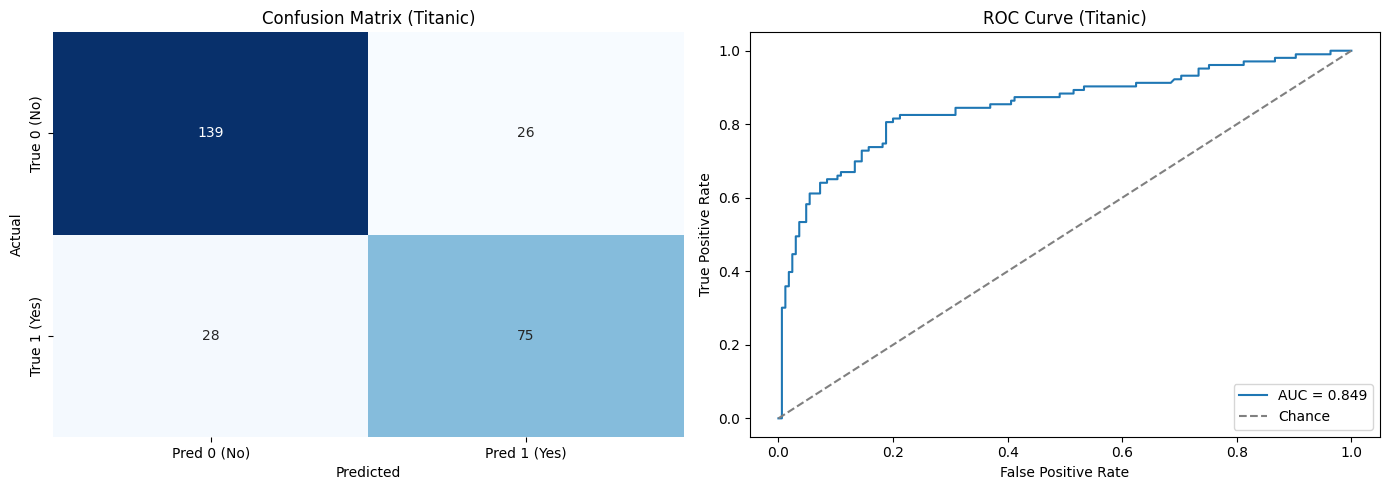

In [11]:
# ===== STUDENT CODE START =====
# 1) Confusion Matrix
cm_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)

# 2) Accuracy
accuracy_titanic = accuracy_score(y_test_titanic, y_pred_titanic)

# 3) Precision
precision_titanic = precision_score(y_test_titanic, y_pred_titanic)

# 4) Recall
recall_titanic = recall_score(y_test_titanic, y_pred_titanic)

# 5) F1-Score
f1_titanic = f1_score(y_test_titanic, y_pred_titanic)

# 6) ROC-AUC (needs probabilities, not hard labels)
roc_auc_titanic = roc_auc_score(y_test_titanic, y_pred_proba_titanic)
# ===== STUDENT CODE END =====

# Print results
print("="*60)
print("TITANIC DATASET - Binary Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(cm_titanic)
print(f"\nAccuracy: {accuracy_titanic:.4f}")
print(f"Precision: {precision_titanic:.4f}")
print(f"Recall: {recall_titanic:.4f}")
print(f"F1-Score: {f1_titanic:.4f}")
print(f"ROC-AUC Score: {roc_auc_titanic:.4f}")

# Visualizations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap and ROC Curve
# ===== STUDENT CODE START =====
# Confusion matrix heatmap
sns.heatmap(
    cm_titanic,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=axes[0],
    xticklabels=["Pred 0 (No)", "Pred 1 (Yes)"],
    yticklabels=["True 0 (No)", "True 1 (Yes)"]
)
axes[0].set_title("Confusion Matrix (Titanic)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC curve
fpr_titanic, tpr_titanic, _ = roc_curve(y_test_titanic, y_pred_proba_titanic)
axes[1].plot(fpr_titanic, tpr_titanic, label=f"AUC = {roc_auc_titanic:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
axes[1].set_title("ROC Curve (Titanic)")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()
# ===== STUDENT CODE END =====


---
## Part 2: Multiclass Classification - Iris Dataset

### Dataset Loading

The Iris dataset is balanced and clean, requiring minimal preprocessing.

In [ ]:
# Load Iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

print("Dataset shape:", X_iris.shape)
print("Target classes:", iris.target_names)
print("\nClass distribution:")
print(pd.Series(y_iris).value_counts().sort_index())
print("\nFirst few rows:")
display(X_iris.head())

print("\n" + "="*60)
print("Feature Statistics (Before Scaling)")
print("="*60)
display(X_iris.describe())

In [ ]:
# Preprocessing: Feature Scaling
# Many sklearn models (e.g., Logistic Regression, SVM, KNN) benefit from scaled features
# StandardScaler standardizes features by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_iris = pd.DataFrame(X_iris_scaled, columns=iris.feature_names)

print("="*60)
print("Feature Statistics (After Scaling)")
print("="*60)
display(X_iris.describe())
print("\nFeatures are now scaled with mean ≈ 0 and std ≈ 1")
print("This improves performance for distance-based and gradient-based models")

---
## ✏️ Exercise 3: Train-Test Split for Balanced Dataset

**Task:** Create a train-test split for the Iris dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_iris`, `X_test_iris`, `y_train_iris`, `y_test_iris`

*Note: Since Iris is a balanced dataset, stratification is optional but still good practice.*

In [ ]:
# ===== STUDENT CODE START =====

# ===== STUDENT CODE END =====

In [ ]:
# Verify the split
print("Train set shape:", X_train_iris.shape)
print("Test set shape:", X_test_iris.shape)
print("\nTrain set class distribution:")
print(pd.Series(y_train_iris).value_counts().sort_index())
print("\nTest set class distribution:")
print(pd.Series(y_test_iris).value_counts().sort_index())

### Model Training Code

Below is the model training code. **Warning** - complete Exercise 3 first.

In [ ]:
# Train a Logistic Regression model for multiclass classification
# This cell should be run AFTER you complete Exercise 3

model_iris = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
model_iris.fit(X_train_iris, y_train_iris)

# Make predictions
y_pred_iris = model_iris.predict(X_test_iris)
y_pred_proba_iris = model_iris.predict_proba(X_test_iris)

print("Model trained successfully!")
print(f"Training set size: {len(X_train_iris)}")
print(f"Test set size: {len(X_test_iris)}")

---
## ✏️ Exercise 4: Multiclass Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Iris model:
1. Confusion Matrix
2. Overall Accuracy
3. Precision (macro, micro, and weighted averages)
4. Recall (macro, micro, and weighted averages)
5. F1-Score (macro, micro, and weighted averages)

**Visualization Requirement:**
- Create a heatmap visualization of the confusion matrix using seaborn with proper class labels

*Tip: For multiclass metrics, check the `average` parameter. Different averaging methods give you different perspectives on model performance.*

**'macro':** (Default in many functions): Calculates the metric for each label and finds their unweighted mean. This does not take label imbalance into account.

**'weighted':** Calculates the metric for each label and finds their average, weighted by support (the number of true instances for each label). This accounts for label imbalance.

**'micro':** Calculates metrics globally by counting the total true positives, false negatives, and false positives.*

In [ ]:

# ===== STUDENT CODE START =====
# ===== END CODE START =====

# Print results
print("="*60)
print("IRIS DATASET - Multiclass Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(cm_iris)
print(f"\nOverall Accuracy: {accuracy_iris:.4f}")
print("\nPrecision:")
print(f"  Macro:    {precision_macro_iris:.4f}")
print(f"  Micro:    {precision_micro_iris:.4f}")
print(f"  Weighted: {precision_weighted_iris:.4f}")
print("\nRecall:")
print(f"  Macro:    {recall_macro_iris:.4f}")
print(f"  Micro:    {recall_micro_iris:.4f}")
print(f"  Weighted: {recall_weighted_iris:.4f}")
print("\nF1-Score:")
print(f"  Macro:    {f1_macro_iris:.4f}")
print(f"  Micro:    {f1_micro_iris:.4f}")
print(f"  Weighted: {f1_weighted_iris:.4f}")

# Visualize Confusion Matrix 


# ===== STUDENT CODE START =====
# ===== END CODE START =====


---
## ✏️ Part 3: Cross-Validation with Confidence Intervals

### Exercise 5: K-Fold Cross-Validation with Confidence Intervals

**Task:** Perform stratified k-fold cross-validation on both datasets and calculate 95% confidence intervals for the F1-scores.

**Requirements:**
1. Use 5-fold stratified cross-validation
2. Calculate cross-validation F1-scores for both Titanic and Iris datasets
3. For each dataset, compute:
   - Mean F1-score
   - Standard deviation
   - 95% confidence interval using the t-distribution

*Tip: Cross-validation returns an array of scores (one per fold). The standard error (SE) is calculated as std/sqrt(n) where n is the number of folds. For a 95% confidence interval with a t-distribution, you'll need the degrees of freedom (n-1). Consider using `scipy.stats.t.interval()`. For F1-score with binary classification, use `scoring='f1'`. For multiclass, use `scoring='f1_macro'`.*

In [ ]:
# ===== STUDENT CODE START =====

# ===== STUDENT CODE END =====